# Image segmentation   UNet-ResNeXt50 


In [1]:
!pip3 install -r requirements.txt

In [2]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid import ImageGrid
plt.style.use("dark_background")
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import sys
import os
import glob
import random
import time
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
from sklearn.model_selection import train_test_split

#custom libraries
from model import UNet, RESNET_UNET

from dataTransformer import DatasetGenerator, dataAugmented, transforms
from train import plot_model_history, compute_iou, TRAINING_MODEL
from metrics import soft_dice_loss
from utils import plot_samples, plot_statistics, random_test_sample, positiv_negativ_diagnosis



In [3]:
# Path to all data
DATA_PATH = "./MRI_Data/"

BASE_LEN = 89 # len(./MRI_Data/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(./MRI_Data/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (./MRI_Data/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 512

## Data preprocessing

In [4]:
Data= []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            Data.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : Data[::2],
                  "path" : Data[1::2]})
df.head()

This is not a dir: ./MRI_Data/README.md
This is not a dir: ./MRI_Data/data.csv


,dirname,path
0,TCGA_DU_8164_19970111,./MRI_Data/TCGA_DU_8164_19970111/TCGA_DU_8164_...
1,TCGA_DU_8164_19970111,./MRI_Data/TCGA_DU_8164_19970111/TCGA_DU_8164_...
2,TCGA_DU_8164_19970111,./MRI_Data/TCGA_DU_8164_19970111/TCGA_DU_8164_...
3,TCGA_DU_8164_19970111,./MRI_Data/TCGA_DU_8164_19970111/TCGA_DU_8164_...
4,TCGA_DU_8164_19970111,./MRI_Data/TCGA_DU_8164_19970111/TCGA_DU_8164_...


In [80]:
# Define Masks/Not masks 
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[BASE_LEN:-END_MASK_LEN]))

In [81]:
# General dataframe using masks and images
general_DF = pd.DataFrame({"patient_code": df_imgs.dirname.values,"img_path": imgs,"mask_path": masks})

general_DF["diagnosis_class"] = general_DF["mask_path"].apply(lambda x: positiv_negativ_diagnosis(x))

In [82]:
#Negative data
Negative_data = general_DF.loc[general_DF['diagnosis_class' ]== 0]
#Positive data
Positive_data = general_DF.loc[general_DF['diagnosis_class'] == 1]

##  Statistic data distribution 

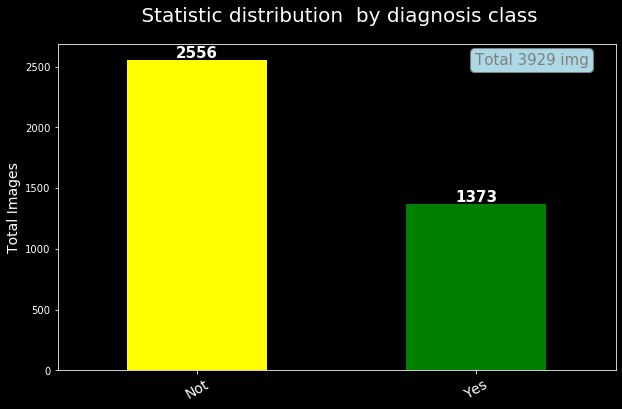

In [83]:
#Plot
from utils import plot_statistics
plot_statistics(general_DF)

## Ploting data 

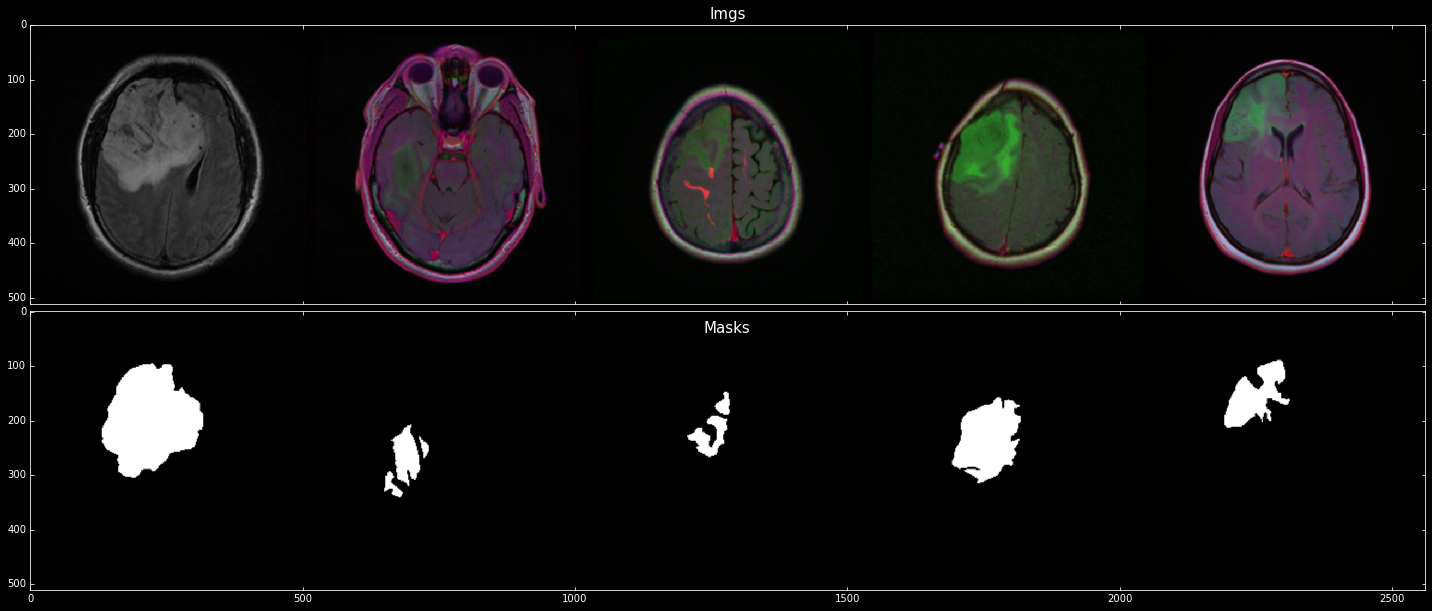

In [84]:
#DATA SIMPLES
Plot_samples_df = general_DF[general_DF["diagnosis_class"] == 1].sample(5).values
plot_samples(Plot_samples_df, IMG_SIZE)


# Data transformation 

In [85]:
# Manage the Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Split data on train val test

In [88]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(general_DF, stratify=general_DF.diagnosis_class, test_size=0.15)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis_class, test_size=0.1)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (590, 4) 
Test: (334, 4)


In [89]:
from dataTransformer import DatasetGenerator, dataAugmented, transforms

# train
train_dataset = DatasetGenerator(general_DF=train_df, transforms=transforms)
train_dataloader = DataLoader(train_dataset, batch_size=26, num_workers=4, shuffle=True)

# val
val_dataset = DatasetGenerator(general_DF=val_df, transforms=transforms)
val_dataloader = DataLoader(val_dataset, batch_size=26, num_workers=4, shuffle=True)

#test
test_dataset = DatasetGenerator(general_DF=test_df, transforms=transforms)
test_dataloader = DataLoader(test_dataset, batch_size=26, num_workers=4, shuffle=True)

Augmentation Visualization

torch.Size([26, 3, 128, 128]) torch.Size([26, 1, 128, 128])


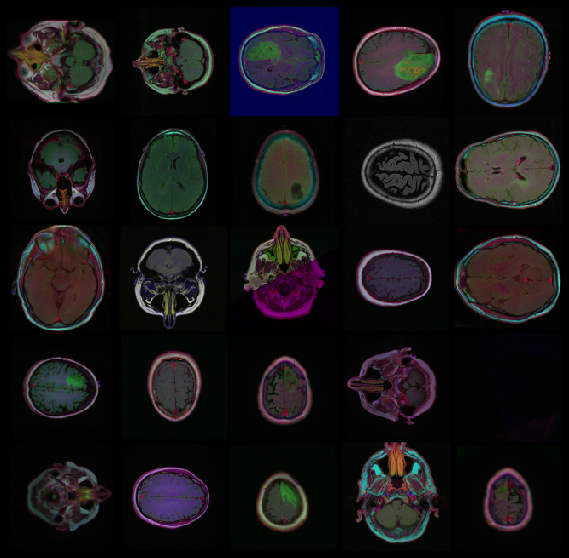

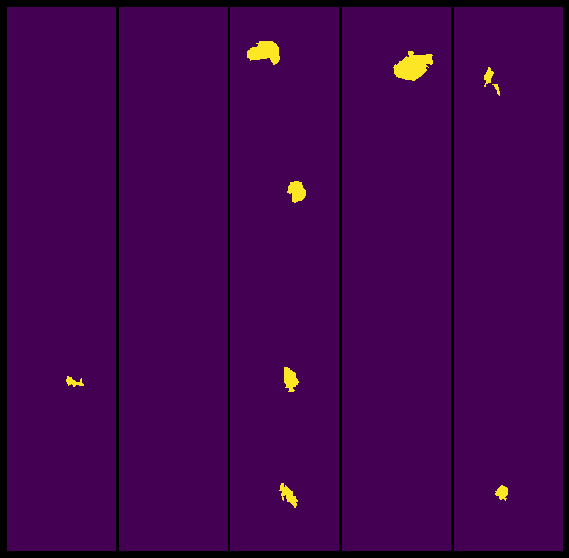

In [90]:
from dataTransformer import dataAugmented
    
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

dataAugmented(images)
dataAugmented(masks, image=False)

## MODEL 

In [ ]:
from model import UNet, RESNET_UNET
from torchvision.models import resnext50_32x4d
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [93]:
unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


## Unet_plus_ResNeXt50 Model Combunation

In [96]:
RESTNET_UNET_MODEL = RESNET_UNET(n_classes=1).to(device)
output = RESTNET_UNET_MODEL(torch.randn(1,3,256,256).to(device))
print(output.shape)

torch.Size([1, 1, 256, 256])


# -----Model Training -------

In [99]:
from metrics import soft_dice_loss
from train import plot_model_history, TRAINING_MODEL

In [101]:
%%time
num_ep = 2  
# Optimizers
optimizer = torch.optim.Adam(RESTNET_UNET_MODEL.parameters(), lr=5e-4)
             
# Train RESTNET_UNET_MODEL
RESTNET_UNET_MODEL_lh, RESTNET_UNET_MODEL_th, RESTNET_UNET_MODEL_vh = TRAINING_MODEL("RESTNET_UNET_MODEL", RESTNET_UNET_MODEL, train_dataloader, val_dataloader, soft_dice_loss, optimizer, False, num_ep)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


Epoch [0]
soft_dice_Loss : 0.43674739424524633 
 IoU on train: 0.5175553995562618 
 IoU on validation: 0.7943467999881932
Epoch [1]
soft_dice_Loss : 0.20213815569877625 
 IoU on train: 0.7666111171967065 
 IoU on validation: 0.8189500798430758
Epoch [2]
soft_dice_Loss : 0.15252180911343674 
 IoU on train: 0.8200814728608197 
 IoU on validation: 0.844915446975044
Epoch [3]
soft_dice_Loss : 0.14927285704119453 
 IoU on train: 0.8232920978425935 
 IoU on validation: 0.7733698052531487
Epoch [4]
soft_dice_Loss : 0.136282408031924 
 IoU on train: 0.8361339600820693 
 IoU on validation: 0.8137128960255815
Epoch [5]
soft_dice_Loss : 0.11590417705733201 
 IoU on train: 0.858983106066117 
 IoU on validation: 0.8714018153231685
Epoch [6]
soft_dice_Loss : 0.1259297173598717 
 IoU on train: 0.8480625230359162 
 IoU on validation: 0.8736577598845972
Epoch [7]
soft_dice_Loss : 0.1339331577564108 
 IoU on train: 0.838801853110731 
 IoU on validation: 0.8723015945782236
Epoch [8]
soft_dice_Loss : 0.11

## Train history 

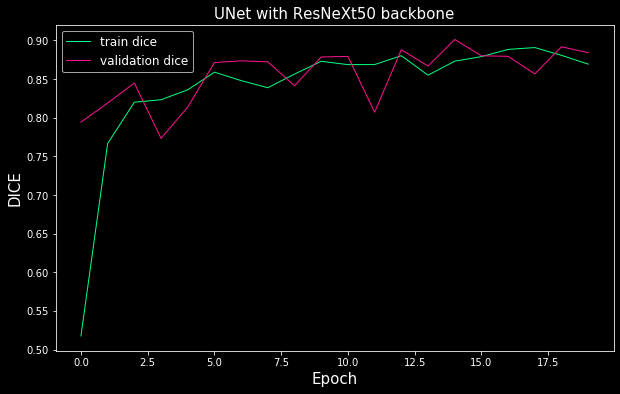

In [105]:
#plot_model_history
plot_model_history("UNet with ResNeXt50 backbone", RESTNET_UNET_MODEL_th, RESTNET_UNET_MODEL_vh, num_ep)

# Test Prediction

### Test IoU

In [106]:
test_iou = compute_iou(RESTNET_UNET_MODEL, test_dataloader)
print(f"""RESTNET_UNET_MODEL\n Decie Coeff of the test images - {np.around(test_iou, 2)}""")

RESTNET_UNET_MODEL
 Decie Coeff of the test images - 0.9


### random test sample

In [ ]:
# image
test_sample = test_df[test_df["diagnosis_class"] == 1].sample(1).values[0]
image = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

#mask
mask = cv2.resize(cv2.imread(test_sample[2]), (128, 128))

# pred
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = RESTNET_UNET_MODEL(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

# pred with tshd
pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.8)] = 0.0
pred_t[np.nonzero(pred_t >= 0.8)] = 255.#1.0
pred_t = pred_t.astype("uint8")

# plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")

plt.show()